<h1>Building and Training FaceNet</h1>

In [6]:
# Project Path
import project_path

# Local package imports
from src.data_loader import DataSplitter
from src.data_loader.FaceRecognitionDataset import FaceRecognitionDataset
from src.model.FaceNet import FaceNet
from src.trainer.FaceNetTrainer import FaceNetTrainer
from src.utils import utils_tensorboard
import src.utils.utils_images as img_util

# Pytorch imports 
import torch
import torchvision
from torchsummary import summary

# General imports
import time

<h3>General/Global Variables</h3>

In [2]:
# Paths 
dataset_dir ="./src/data/toy_dataset/images/"
labels_path="./src/data/toy_dataset/labels.txt"

# Hyperparameters
batch_size = 2
val_ratio = 0.10
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<h3>Data loading and preprocessing</h3>

In [3]:
print("--------------------------------------------------------------------------")
print("Create dataset...")
dataset = FaceRecognitionDataset(dataset_dir=dataset_dir, labels_path=labels_path)
print(f"Created dataset! Number of samples: {len(dataset)}")
print("--------------------------------------------------------------------------")
print("Split dataset...")
train_dataset, val_dataset = DataSplitter.split_train_test(dataset=dataset, val_ratio=val_ratio)
print(f"Splitted dataset! Number of training samples: {len(train_dataset)}, number of validation samples: {len(val_dataset)}")
print("--------------------------------------------------------------------------")
print("Create data loaders...")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=4,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         num_workers=4)
print(f"Created data loaders! Batch size: {batch_size}")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create dataset...
Created dataset! Number of samples: 180
--------------------------------------------------------------------------
Split dataset...
Splitted dataset! Number of training samples: 162, number of validation samples: 18
--------------------------------------------------------------------------
Create data loaders...
Created data loaders! Batch size: 2
Number of batches in train_loader: 81
Number of batches in val_loader: 9
--------------------------------------------------------------------------


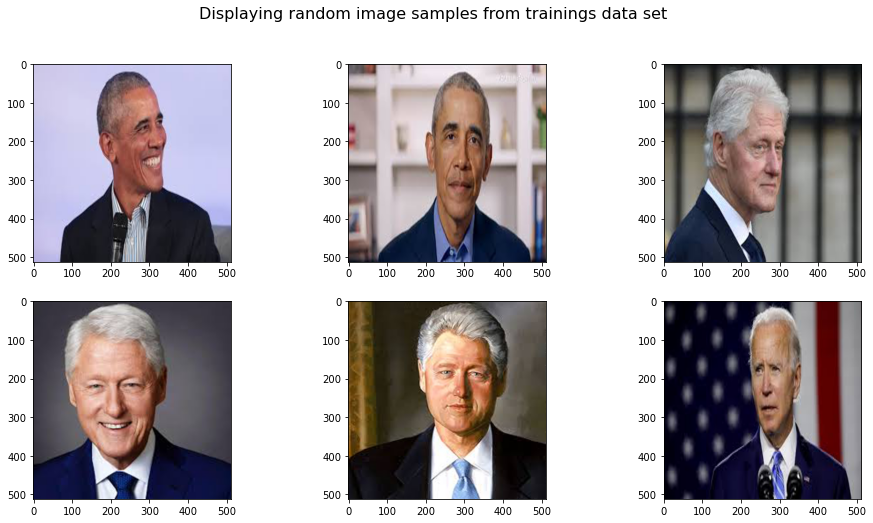

In [4]:
# Random image samples from data set
import matplotlib.pyplot as plt
from PIL import Image

rows, columns = (2, 3)
fig, ax_arr = plt.subplots(rows, columns, figsize=(16,8))
to_pil = torchvision.transforms.ToPILImage()

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        img = to_pil(train_dataset[j+45][0][i])
        ax.imshow(img)

fig.suptitle('Displaying random image samples from trainings data set', fontsize=16)
plt.show() 

<h3>Model building and training</h3>

<center><img src='documentation/images/FaceNet.png'></center>
Source: https://dvl.in.tum.de/slides/adl4cv-ws18/2.Siamese.pdf

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
print("--------------------------------------------------------------------------")
print("Create model...")
model = FaceNet().to(device)
print("Created model!")
print(f'Model is on cuda: {next(model.parameters()).is_cuda}')
#print(model)
summary(model, [(3, 512, 512),(3, 512, 512),(3, 512, 512)], batch_size=batch_size)
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create model...
Created model!
Model is on cuda: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [2, 128, 510, 510]           3,584
         MaxPool2d-2         [2, 128, 255, 255]               0
             PReLU-3         [2, 128, 255, 255]             128
            Conv2d-4          [2, 64, 253, 253]          73,792
         MaxPool2d-5          [2, 64, 126, 126]               0
             PReLU-6          [2, 64, 126, 126]              64
            Conv2d-7          [2, 32, 124, 124]          18,464
         MaxPool2d-8            [2, 32, 62, 62]               0
             PReLU-9            [2, 32, 62, 62]              32
           Conv2d-10            [2, 16, 60, 60]           4,624
        MaxPool2d-11            [2, 16, 30, 30]               0
            PReLU-12            [2, 16

In [7]:
print("--------------------------------------------------------------------------")
print("Create tensorboard_writer...")
tensorboard_writer = utils_tensorboard.MySummaryWriter(numb_batches=len(train_loader), batch_size=batch_size, experiment_name="FaceNet")
print("Created tensorboard_writer!")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create tensorboard_writer...
nonempty logpath
logpath:  ..\logs\FaceNet\run_1(34)
tensorboard is up: http://localhost:6006
Created tensorboard_writer!
--------------------------------------------------------------------------


In [8]:
print("--------------------------------------------------------------------------")
print("Create trainer...")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = FaceNetTrainer(model=model, 
                                train_loader=train_loader,
                                valid_loader=val_loader, 
                                test_loader=val_loader,
                                optimizer=optimizer, 
                                tensorboard_writer=tensorboard_writer)
print("Created trainer!")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Create trainer...
Created trainer!
--------------------------------------------------------------------------


<h4>Training</h4>

<center><img src='documentation/images/TripletLoss.png'></center>
Source: https://dvl.in.tum.de/slides/adl4cv-ws18/2.Siamese.pdf

In [9]:
print("start training")
trainer.train(epochs=4)

start training
[0/4][4/81] => loss: 0.9459080696105957
[0/4][9/81] => loss: 1.3992570638656616
[0/4][14/81] => loss: 0.10823929309844971
[0/4][19/81] => loss: 0.0
[0/4][24/81] => loss: 0.39386385679244995
[0/4][29/81] => loss: 4.174500942230225
[0/4][34/81] => loss: 1.0550487041473389
[0/4][39/81] => loss: 0.0
[0/4][44/81] => loss: 0.5496218800544739
[0/4][49/81] => loss: 0.47920405864715576
[0/4][54/81] => loss: 0.0
[0/4][59/81] => loss: 0.0
[0/4][64/81] => loss: 0.0
[0/4][69/81] => loss: 0.0
[0/4][74/81] => loss: 0.0
[0/4][79/81] => loss: 0.41499996185302734
####### EPOCH 0 DONE ####### (computation time: 13.47398567199707) ##################
[0/4][4/81] => loss: 0.0
[0/4][9/81] => loss: 0.0
[0/4][14/81] => loss: 0.0
[0/4][19/81] => loss: 0.0
[0/4][24/81] => loss: 0.0
[0/4][29/81] => loss: 0.5729519128799438
[0/4][34/81] => loss: 0.0
[0/4][39/81] => loss: 0.0
[0/4][44/81] => loss: 0.0
[0/4][49/81] => loss: 0.0
[0/4][54/81] => loss: 0.0
[0/4][59/81] => loss: 0.0
[0/4][64/81] => loss: 

In [10]:
# Store model parameter
model_path = f"./src/saved/models/siamese_network_{time.time()}.pt"
torch.save(model.state_dict(), model_path)

<h3>Model evaluation</h3>

In [11]:
model = FaceNet().to(device)

# load the state dict and pass it to the load_state_dict function
model.load_state_dict(torch.load(model_path))
model.eval()

FaceNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): PReLU(num_parameters=128)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): PReLU(num_parameters=64)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): PReLU(num_parameters=32)
    (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): PReLU(num_parameters=16)
    (12): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): PReLU(num_parameters=8)
  )
  (image_embedding): Sequential(
    (0): Linear(in_features=1

--------------------------------------------------------------------------------------
Row j=0, Distance between Anchor and Positive: 17.22745132446289, Distance between Anchor and Negative: 45.7401237487793
Row j=0, Distance between Anchor and Positive: 17.22745132446289, Distance between Anchor and Negative: 45.7401237487793
--------------------------------------------------------------------------------------
Row j=1, Distance between Anchor and Positive: 21.036603927612305, Distance between Anchor and Negative: 52.906681060791016
Row j=1, Distance between Anchor and Positive: 21.036603927612305, Distance between Anchor and Negative: 52.906681060791016


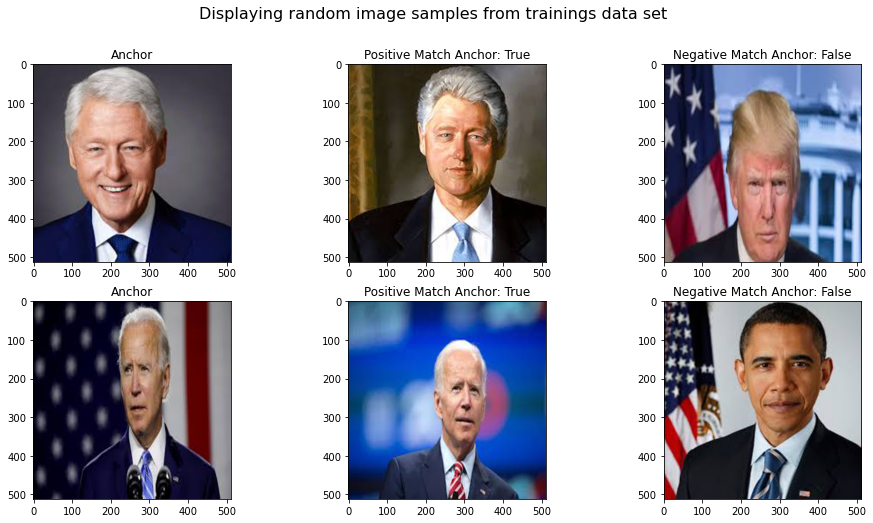

In [23]:
# Random image samples from data set
import matplotlib.pyplot as plt
from PIL import Image

rows, columns = (2, 3)
fig, ax_arr = plt.subplots(rows, columns, figsize=(16,8))
to_pil = torchvision.transforms.ToPILImage()

sample_idx = 0 #8 #11 #5

for j, row in enumerate(ax_arr):
    print('--------------------------------------------------------------------------------------')
    for i, ax in enumerate(row):
        img = to_pil(val_dataset[j+sample_idx][0][i])
        if i == 0:
            ax.set_title(f'Anchor')
        else:
            dist_ap, dist_an, match = trainer.inference(val_dataset[j+sample_idx][0][0].unsqueeze(0), val_dataset[j+sample_idx][0][1].unsqueeze(0), val_dataset[j+sample_idx][0][2].unsqueeze(0))
            print(f'Row j={j}, Distance between Anchor and Positive: {dist_ap.item()}, Distance between Anchor and Negative: {dist_an.item()}')
            if i == 1:
                ax.set_title(f'Positive Match Anchor: {match}')
            if i == 2:
                ax.set_title(f'Negative Match Anchor: {not match}')
        ax.imshow(img)

fig.suptitle('Displaying random image samples from trainings data set', fontsize=16)
plt.show()